
# Project : Kaggle project CrimeCast: Forecasting Crime Categories

### Name : Amit Devatte
### IIT Madras Machine Learning Project
### Kaggle Completitions : [https://www.kaggle.com/competitions/crime-cast-forecasting-crime-categories/overview]


### Overview
This dataset offers a comprehensive snapshot of criminal activities within the city. It encompasses various aspects of each incident, including date, time, location, victim demographics, and more.

By leveraging machine learning techniques, participants can analyze this rich dataset to predict crime categories, enhance law enforcement strategies, and bolster public safety measures.

Your task is straightforward: Develop models capable of accurately predicting the crime categories based on this information.

Step up and demonstrate your prowess in anticipating crime categories – it's your chance to transform this data into actionable insights!

Dataset Description
In this competition, you'll analyze a dataset filled with information about crime incidents. You'll look at where the incidents happened, details about the victims, and other important factors.

Your goal is to use this data to predict the type of crime that occurred.

### Dataset Overview:

Welcome to the Crime Category Prediction Challenge! Our dataset serves as your gateway to exploring the world of crime incidents. Each entry encapsulates a unique narrative, featuring details such as incident locations, victim demographics, and other key attributes. Your task is to explore this comprehensive dataset and construct predictive models that can forecast the category of crime for each incident. Unleash your creativity and analytical skills to uncover the underlying patterns.

**Data Files:**

The dataset consists of the following files:

train.csv: The training set, inclusive of the target variable 'crime_category' and relevant feature attributes.
test.csv: The test set, containing similar feature attributes but excluding the target variable 'crime_category', as it is the variable to be predicted.
sample_submission.csv: A sample submission file provided in the correct format for competition submissions.

**Columns Description:**

Location: Street address of the crime incident.

* Cross_Street: Cross street of the rounded address.
* Latitude: Latitude coordinates of the crime incident.
* Longitude: Longitude coordinates of the crime incident.
* Date_Reported: Date the incident was reported.
* Date_Occurred: Date the incident occurred.
* Time_Occurred: Time the incident occurred in 24-hour military time.
* Area_ID: LAPD's Geographic Area number.
* Area_Name: Name designation of the LAPD Geographic Area.
* Reporting_District_no: Reporting district number.
* Part 1-2: Crime classification.
* Modus_Operandi: Activities associated with the suspect.
* Victim_Age: Age of the victim.
* Victim_Sex: Gender of the victim.
* Victim_Descent: Descent code of the victim.
* Premise_Code: Premise code indicating the location of the crime.
* Premise_Description: Description of the premise code.
* Weapon_Used_Code: Weapon code indicating the type of weapon used.
* Weapon_Description: Description of the weapon code.
* Status: Status of the case.
* Status_Description: Description of the status code.
* Crime_Category: The category of the crime (Target Variable)



In [ ]:
# @title
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/)
# that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crime-cast-forecasting-crime-categories/sample.csv
/kaggle/input/crime-cast-forecasting-crime-categories/train.csv
/kaggle/input/crime-cast-forecasting-crime-categories/test.csv


# Importing Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler,LabelEncoder,OneHotEncoder, StandardScaler,OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import lightgbm as lgb
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score,
                                    learning_curve,KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, log_loss, ConfusionMatrixDisplay

## Display and warning setting

In [ ]:
pd.set_option('display.max_categories',200)
pd.set_option('display.max_columns',50)
import warnings
warnings.filterwarnings("ignore")

# Loading Datasets

In [ ]:
# Loading the csv file
data_train = pd.read_csv("/kaggle/input/crime-cast-forecasting-crime-categories/train.csv")
data_test = pd.read_csv("/kaggle/input/crime-cast-forecasting-crime-categories/test.csv")

df_train = data_train.copy()
df_test = data_test.copy()


#   EDA (Exploratory Data Analysis)

* The shape of training dataset is 20,000 rows(samples) and 22 columns(features =21 + Target =1)

**Features**
   * Numerical:
1. **Latitude** : no null values, diferent decimal length, 0.0 values, outliers present
1. **Longitude** :no null values, diferent decimal length,0.0 values,outliers present. can we concate lat and long for clustering using k-means cluster.
1. **Time_Occurred** : Needs formatting, Its in 2400 hours format.
       * Think about binning indaystime (morning,afternoon, evening,night)
       * investigate on 1,2,3 digit number samples.need to convert.
       * can use only Hours for analysis
1. **Area_ID** : It is linked with 'Area_Name' Feature. Data is clean.convert to int or cat
1. **Reporting_District_no**
1. **Part 1-2** : Type of cases. 1 - voilent 2- moderate
1. **Victim_Age** : some -ve numbers and many 0 values. Need preprocessing. or make binary category classification
1. **Premise_Code** : This is linked with 'Premise_Description' feature
1. **Weapon_Used_Code** : This is linked with 'Weapon_Description' feature

* Categorical:

    1.     **Location** : it is text data with many spaces between words.
    1.     **Cross_Street** : high number of missing values.make binary category classification
    1.     **Date_Reported** : need to convert in to dattime and extract day, month, year, weekday, month day.
    1.     **Date_Occurred** :need to convert in to dattime and extract day, month, year, weekday, month day.
    1.     **Area_Name** : highly correlated with Area ID. Area ID description.
    1.     **Modus_Operandi** : Modus operandi codes. multiple code for each record and missing values.[Modus Operandi Code details](https://data.lacity.org/api/views/d5tf-ez2w/files/8957b3b1-771a-4686-8f19-281d23a11f1b?download=true&filename=MO_CODES_Numerical_20180627.pdf)
    1.     **Victim_Sex** :
    1.     **Victim_Descent**
    1.     **Premise_Description** description for Premised ID
    1.     **Weapon_Description** Description for Weapon_used_code
    1.     **Status** : 5 types of status. arrest done or not for juvenile and adult.
    1.     **Status_Description** : Description of status.
    1.     **Crime_Category** : This is Target vector


In [ ]:
df_train.shape

(20000, 22)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Location               20000 non-null  object 
 1   Cross_Street           3448 non-null   object 
 2   Latitude               20000 non-null  float64
 3   Longitude              20000 non-null  float64
 4   Date_Reported          20000 non-null  object 
 5   Date_Occurred          20000 non-null  object 
 6   Time_Occurred          20000 non-null  float64
 7   Area_ID                20000 non-null  float64
 8   Area_Name              20000 non-null  object 
 9   Reporting_District_no  20000 non-null  float64
 10  Part 1-2               20000 non-null  float64
 11  Modus_Operandi         17259 non-null  object 
 12  Victim_Age             20000 non-null  float64
 13  Victim_Sex             17376 non-null  object 
 14  Victim_Descent         17376 non-null  object 
 15  Pr

In [ ]:
df_train.head()

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,Part 1-2,Modus_Operandi,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description,Crime_Category,Is_CrossStreet,Victim_Present,Rep_Dist_no,PCode,Arrest_done
0,4500 CARPENTER AV,0,34.1522,-118.3910,03/09/2020 12:00:00 AM,03/06/2020 12:00:00 AM,1800.0,15.0,N Hollywood,1563,1,0385,75.0,M,W,101.0,STREET,0.0,0,IC,Invest Cont,Property Crimes,0,1,63,1,0
1,45TH ST,ALAMEDA ST,34.0028,-118.2391,02/27/2020 12:00:00 AM,02/27/2020 12:00:00 AM,1345.0,13.0,Newton,1367,1,0906 0352 0371 0446 1822 0344 0416 0417,41.0,M,H,216.0,SWAP MEET,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes,1,1,67,2,0
2,600 E MARTIN LUTHER KING JR BL,0,34.0111,-118.2653,08/21/2020 12:00:00 AM,08/21/2020 12:00:00 AM,605.0,13.0,Newton,1343,0,0329 1202,67.0,M,B,501.0,SINGLE FAMILY DWELLING,0.0,0,IC,Invest Cont,Property Crimes,0,1,43,5,0
3,14900 ORO GRANDE ST,0,34.2953,-118.4590,11/08/2020 12:00:00 AM,11/06/2020 12:00:00 AM,1800.0,19.0,Mission,1924,1,0329 1300,61.0,M,H,101.0,STREET,0.0,0,IC,Invest Cont,Property Crimes,0,1,24,1,0
4,7100 S VERMONT AV,0,33.9787,-118.2918,02/25/2020 12:00:00 AM,02/25/2020 12:00:00 AM,1130.0,12.0,77th Street,1245,1,0416 0945 1822 0400 0417 0344,0.0,X,X,401.0,MINI-MART,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes,0,0,45,4,0


In [ ]:
df_train.isna().sum()

Location                     0
Cross_Street             16552
Latitude                     0
Longitude                    0
Date_Reported                0
Date_Occurred                0
Time_Occurred                0
Area_ID                      0
Area_Name                    0
Reporting_District_no        0
Part 1-2                     0
Modus_Operandi            2741
Victim_Age                   0
Victim_Sex                2624
Victim_Descent            2624
Premise_Code                 0
Premise_Description          5
Weapon_Used_Code         12665
Weapon_Description       12665
Status                       0
Status_Description           0
Crime_Category               0
dtype: int64

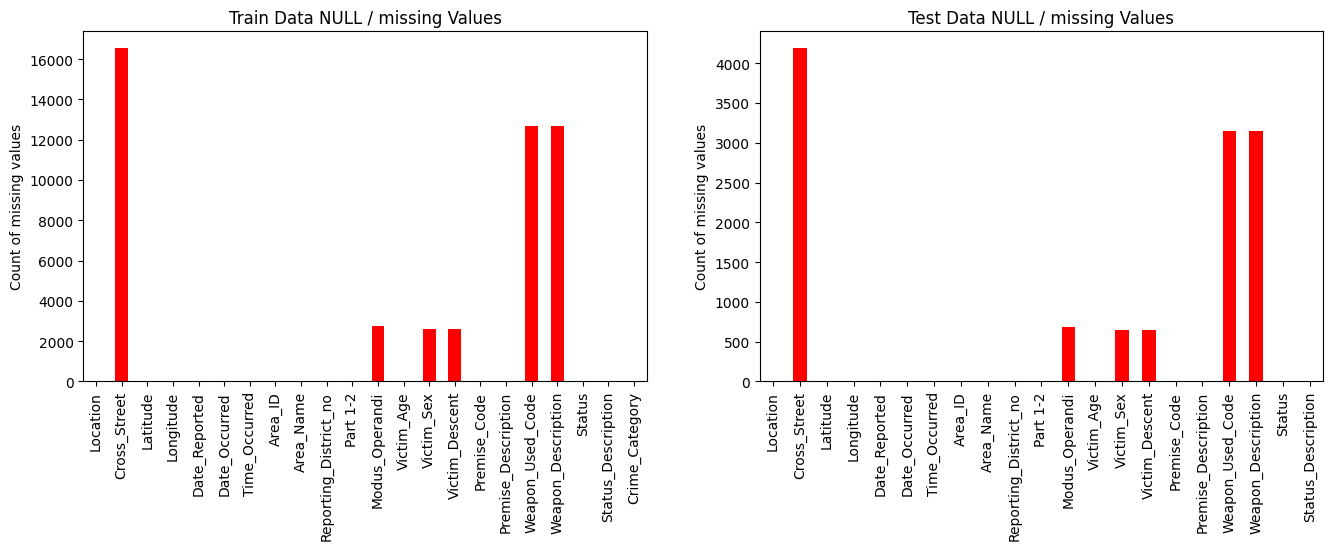

In [ ]:
plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
df_train.isnull().sum().plot(kind='bar',title='Train Data NULL / missing Values', 
                             ylabel='Count of missing values',color='red')
plt.subplot(2, 2, 2)
df_test.isnull().sum().plot(kind='bar',title='Test Data NULL / missing Values', 
                            ylabel='Count of missing values',color='red')
plt.show()

In [ ]:
print("Duplicate records in train dataset: ", df_train.duplicated().sum())
print("Duplicate records in test dataset: ", df_test.duplicated().sum())

#13 records are found duplicated, We may keep them as we may assume that similar crimes occure multiple times,
# as we can't differentiate as crime_ID unique nubers are not provided.

Duplicate records in train dataset:  13
Duplicate records in test dataset:  3


In [ ]:
# Numnerical statistical Analysis
df_train.describe()

,Latitude,Longitude,Time_Occurred,Area_ID,Reporting_District_no,Part 1-2,Victim_Age,Premise_Code,Weapon_Used_Code
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,7335.000000
mean,33.940704,-117.893072,1352.380350,10.834250,1129.599200,1.418150,30.135000,297.176950,366.405044
std,2.126810,7.377726,646.100291,6.033166,603.330519,0.493267,21.863645,212.007298,120.485687
min,0.000000,-118.663400,1.000000,1.000000,101.000000,1.000000,-2.000000,101.000000,101.000000
25%,34.009200,-118.429700,930.000000,6.000000,632.000000,1.000000,12.000000,101.000000,312.000000
50%,34.058700,-118.323000,1430.000000,11.000000,1162.000000,1.000000,31.000000,203.000000,400.000000
75%,34.165025,-118.274400,1900.000000,16.000000,1622.000000,2.000000,46.000000,501.000000,400.000000
max,34.328100,0.000000,2359.000000,21.000000,2197.000000,2.000000,99.000000,969.000000,515.000000


* Longitude and Latitude contains 0 values (missing) and also having outliers.
* Victim_Age having -ve (missing) values.std is high, 4828 values are Zero. last quantile indicate outliers.

In [ ]:
corr = df_train.select_dtypes(include =['float64','int32']).corr()
corr

,Latitude,Longitude,Time_Occurred,Area_ID,Reporting_District_no,Part 1-2,Victim_Age,Premise_Code,Weapon_Used_Code
Latitude,1.000000,-0.998910,0.005952,0.018411,0.017928,-0.036357,0.003195,-0.011293,-0.017656
Longitude,-0.998910,1.000000,-0.005361,-0.006480,-0.006139,0.036373,-0.002252,0.011205,0.019185
Time_Occurred,0.005952,-0.005361,1.000000,0.012346,0.012127,-0.028881,-0.017798,-0.057534,-0.016911
Area_ID,0.018411,-0.006480,0.012346,1.000000,0.999024,-0.002518,0.028966,0.004045,-0.027243
Reporting_District_no,0.017928,-0.006139,0.012127,0.999024,1.000000,-0.002108,0.028721,0.004121,-0.027117
Part 1-2,-0.036357,0.036373,-0.028881,-0.002518,-0.002108,1.000000,0.186780,0.254579,0.419642
Victim_Age,0.003195,-0.002252,-0.017798,0.028966,0.028721,0.186780,1.000000,0.191313,0.056768
Premise_Code,-0.011293,0.011205,-0.057534,0.004045,0.004121,0.254579,0.191313,1.000000,0.196771
Weapon_Used_Code,-0.017656,0.019185,-0.016911,-0.027243,-0.027117,0.419642,0.056768,0.196771,1.000000


<Axes: >

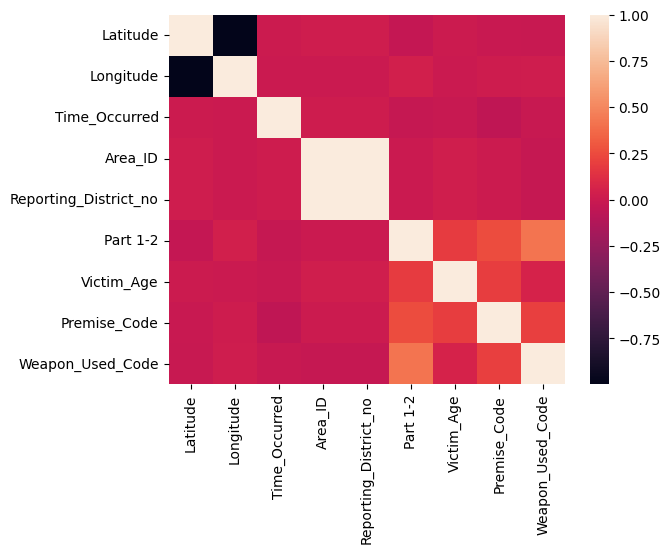

In [ ]:
sns.heatmap(corr)

* Insight from correlation heat map is there is very strong positive corelation in Reporting_District_no and Area_ID.
* correlation beween Reported_Month and Occured_Month are higly related . Correlation-> 0.903226 .So we can Drop Reported month column.

In [ ]:
# Categorical statistical Analysis
df_train.select_dtypes(include = 'object').describe()

,Location,Cross_Street,Date_Reported,Date_Occurred,Area_Name,Modus_Operandi,Victim_Sex,Victim_Descent,Premise_Description,Weapon_Description,Status,Status_Description,Crime_Category
count,20000,3448,20000,20000,20000,17259,17376,17376,19995,7335,20000,20000,20000
unique,12399,1495,811,366,21,10489,4,17,216,57,5,5,6
top,6TH,BROADWAY,07/13/2020 12:00:00 AM,01/01/2020 12:00:00 AM,77th Street,0344,M,H,STREET,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes
freq,33,56,87,137,1345,826,8538,6143,5033,3990,15236,15236,11666


* Hispanian are most in Vistim_descent with 6143 occurances.
* 5033 crimes are on street ( Premise_Description)
* 11666 are from Property Crimes category.

In [ ]:
var1 ='Status'
contingency_table1 = pd.crosstab(df_train[var1], df_train['Crime_Category'],)
contingency_table1


Crime_Category,Crimes against Persons,Crimes against Public Order,Fraud and White-Collar Crimes,Other Crimes,Property Crimes,Violent Crimes
Status,,,,,,
AA,69,323,38,33,753,838
AO,80,465,37,28,550,1437
IC,74,1011,1279,117,10320,2435
JA,1,6,0,1,35,27
JO,1,3,1,0,8,30


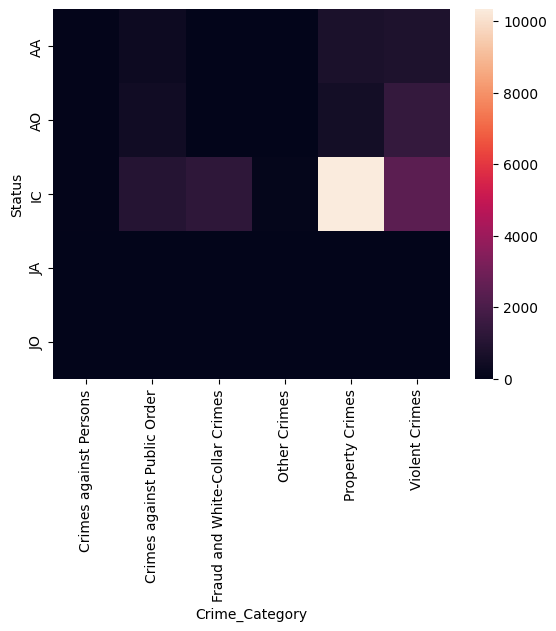

In [ ]:
sns.heatmap(contingency_table1)
plt.show()

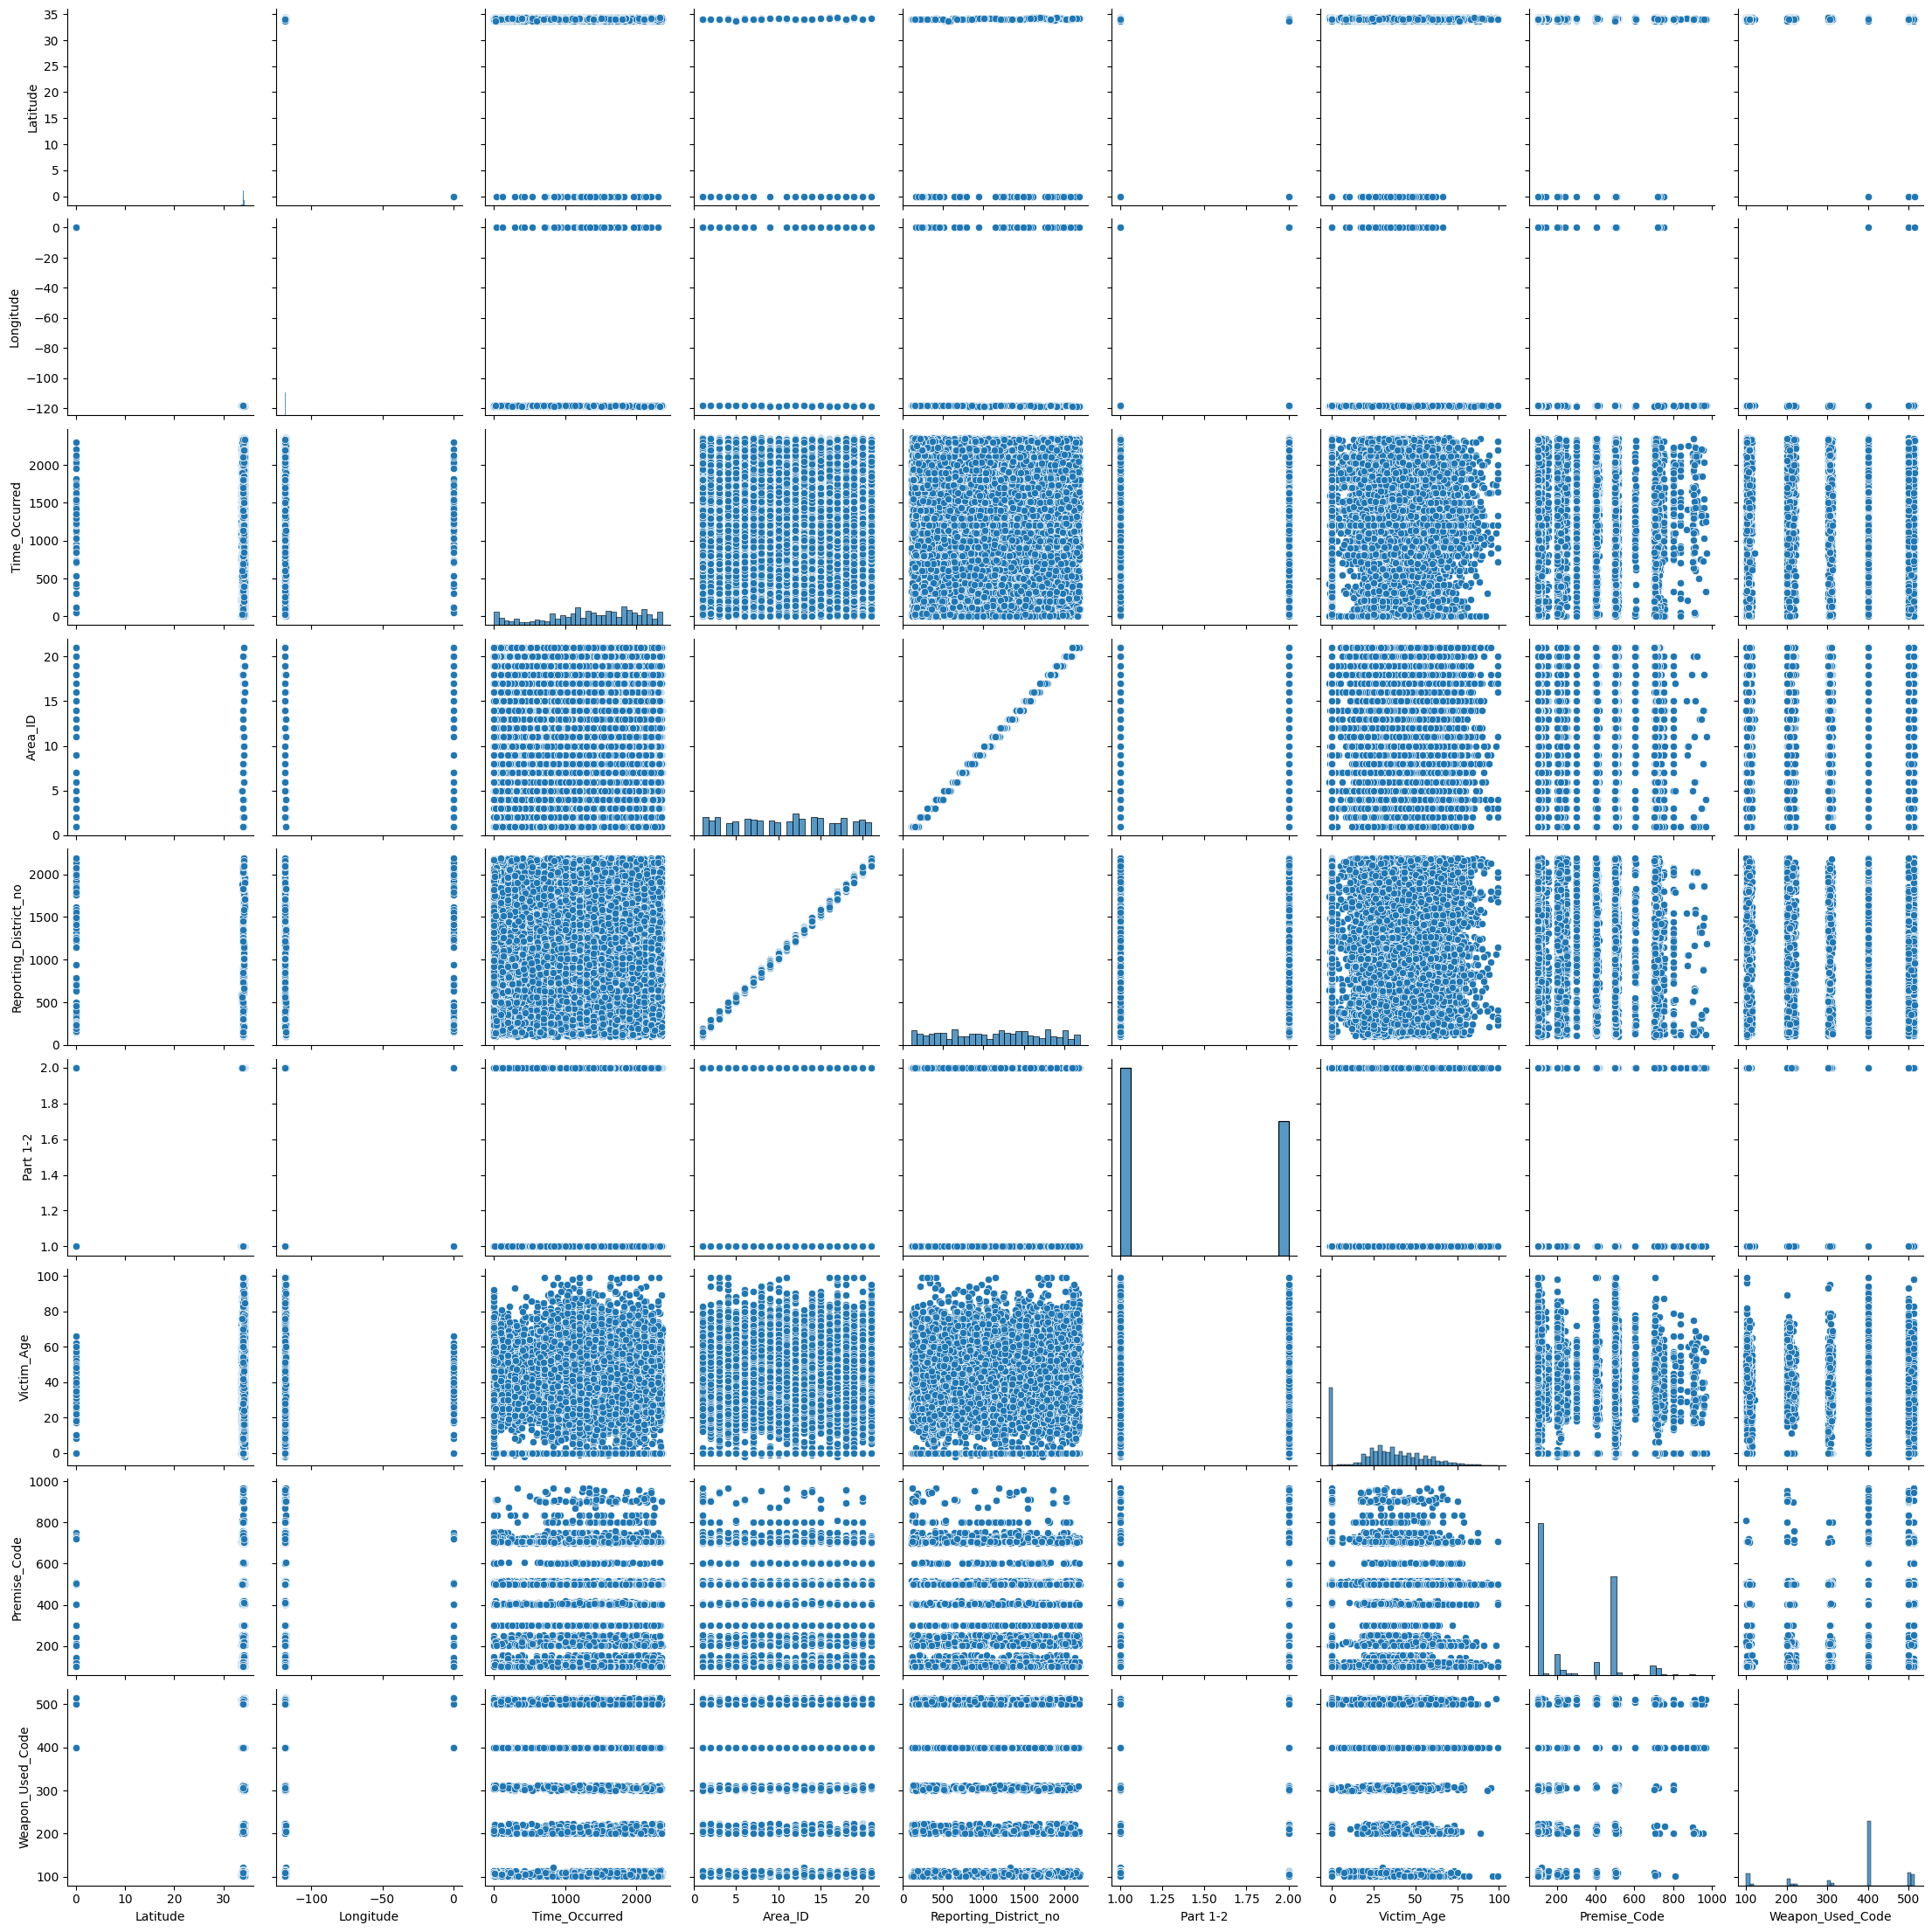

In [ ]:
sns.pairplot(df_train,diag_kind='hist')
plt.show()

# Preprocessing Train Data

In [ ]:
lat_long_missing = df_train[(df_train['Latitude'] == 0) & (df_train['Longitude']==0)].index
df_train.drop(lat_long_missing, inplace=True)
df_train.shape
# Do not drop records from test data as it will give error because for submission.csv we have to provide 5000 rows.

(19922, 22)

**Interesting findings:**
* in Modus operandi codes, we carefully study it is 4 digit code and first 2 digit has certain meanings
and based on that next 2 digits have list of categoris. details in below linked pdf
[Modus Operandi Code details](https://data.lacity.org/api/views/d5tf-ez2w/files/8957b3b1-771a-4686-8f19-281d23a11f1b?download=true&filename=MO_CODES_Numerical_20180627.pdf)

## Processing Outliers and invalid values

In [ ]:
#Removing -ve values and assigning 0.
df_train['Victim_Age'] = df_train['Victim_Age'].apply(lambda x: 0 if x < 0 else x)

<Axes: >

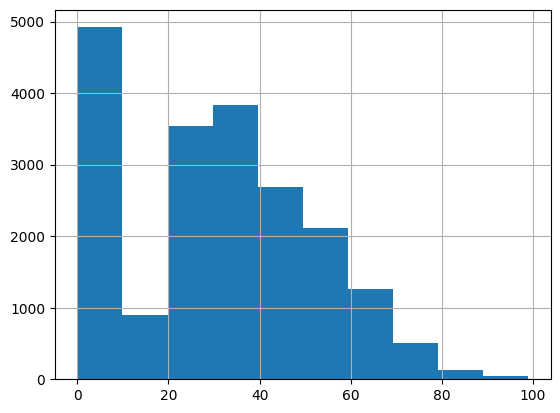

In [ ]:
df_train['Victim_Age'].hist()

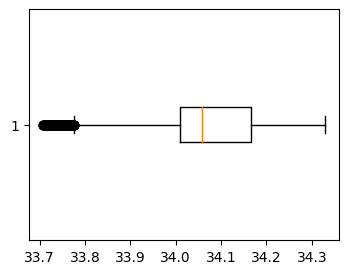

In [ ]:
# box plot for finding outliers ( lattitude, longitude and victim_age)
data =[df_train['Latitude']]
fig, ax = plt.subplots(figsize = (4,3))
ax.boxplot(data, vert =False)
plt.show()

In [ ]:
var = 'Latitude'
Q1 = df_train[var].quantile(0.25)
Q3 = df_train[var].quantile(0.75)
IQR = Q3 - Q1
low_bound = Q1 - 1.5 * IQR
upper_bound = Q3 +  1.5 * IQR
df_train = df_train[(df_train[var] > low_bound) & (df_train[var] < upper_bound)]
df_train.shape

(19462, 22)

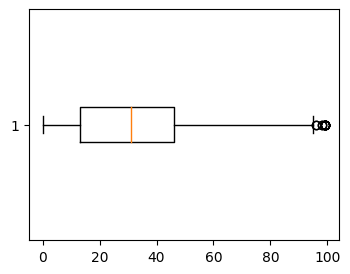

In [ ]:
# box plot for finding outliers ( lattitude, longitude and victim_age)
data =[df_train['Victim_Age']]
fig, ax = plt.subplots(figsize = (4,3))
ax.boxplot(data, vert =False)
plt.show()

In [ ]:
var = 'Victim_Age'
Q1 = df_train[var].quantile(0.25)
Q3 = df_train[var].quantile(0.75)
IQR = Q3 - Q1
low_bound = Q1 - 1.5 * IQR
upper_bound = Q3 +  1.5 * IQR
df_train = df_train[(df_train[var] > low_bound) & (df_train[var] < upper_bound)]
df_train.shape

(19447, 22)

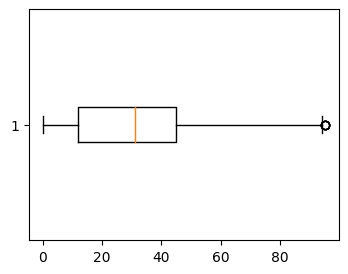

In [ ]:
# box plot After removing outliers from victim_age)
data =[df_train['Victim_Age']]
fig, ax = plt.subplots(figsize = (4,3))
ax.boxplot(data, vert =False)
plt.show()

In [ ]:
#train data
df_train.fillna(value =0, inplace =True)
df_train['Is_CrossStreet'] = df_train['Cross_Street'].apply(lambda x : 0 if x == 0 else 1)
df_train['Victim_Present'] = df_train['Victim_Age'].apply(lambda x : 0 if x <= 0 else 1)

df_train['Reporting_District_no'] = df_train['Reporting_District_no'].astype(int)
df_train['Rep_Dist_no'] = df_train['Reporting_District_no'].apply(lambda x: str(x)[-2:])
# extracted last 2 characters from District_no, first 2 are same as Area_ID
df_train['Rep_Dist_no'] = df_train['Rep_Dist_no'].astype(int)

df_train['Part 1-2'] = df_train['Part 1-2'].astype(int)
df_train['Part 1-2'] = df_train['Part 1-2'].apply(lambda x: 0 if x == 1 else 1)

df_train['PCode'] = df_train['Premise_Code'].apply(lambda x: int(x/100))

df_train['Arrest_done'] = df_train['Status'].map({'IC':0,'AO':0, 'AA':1, 'JA':1, 'JO':0})


In [ ]:
#train data
# Converting Date_Reported into year, month, weekday. in train data
df_train['Reported_Year'] = pd.to_datetime(df_train.Date_Reported).dt.year
df_train['Reported_Month'] = pd.to_datetime(df_train.Date_Reported).dt.month
df_train['Reported_day'] = pd.to_datetime(df_train.Date_Reported).dt.day
df_train['Reported_Weekday'] = pd.to_datetime(df_train.Date_Reported).dt.weekday

# Converting Date_Occurred into year, month, weekday in train data
df_train['Occured_Year'] = pd.to_datetime(df_train.Date_Occurred).dt.year
df_train['Occured_Month'] = pd.to_datetime(df_train.Date_Occurred).dt.month
df_train['Occured_day'] = pd.to_datetime(df_train.Date_Occurred).dt.day
df_train['Occured_Weekday'] = pd.to_datetime(df_train.Date_Occurred).dt.weekday
df_train['DayOfYear'] = (pd.to_datetime(df_train['Date_Occurred'])).dt.dayofyear

# converting df_test ['Time_Occurred'] column to %h%M format as done for train column
df_train['Time_Occurred_Hour'] = pd.to_datetime(df_train['Time_Occurred'].
                                                astype(int).astype(str).str.zfill(4),format ='%H%M').dt.hour
df_train['Days_Lapsed'] = (pd.to_datetime(df_train['Date_Reported']) 
                           - pd.to_datetime(df_train['Date_Occurred'])).dt.days

## Encoding of Label vector ('Crime_Category)

In [ ]:
le = LabelEncoder()
df_train['Crime_Category'] = le.fit_transform(df_train['Crime_Category'])
df_train['Crime_Category'].shape

(19447,)

**Crime_Category Encoded as below******
* 'Property Crimes' = 4
* 'Violent Crimes'= 5   
* 'Other Crimes' = 1
* 'Crimes against Public Order' = 2
* 'Fraud and White-Collar Crimes' = 0
* 'Crimes against Persons' = 3

In [ ]:
#  Remember to  Drop columns Crime_Category from list of Test data as this is Target label

columns_train = ['Latitude', 'Longitude','Area_ID','Reporting_District_no', 'Part 1-2', 'Modus_Operandi', 'Victim_Age',
       'Victim_Sex', 'Victim_Descent', 'Premise_Code','Weapon_Used_Code', 'Status','Crime_Category',
         'Is_CrossStreet','Victim_Present','Days_Lapsed','Occured_day','Occured_Weekday', 'Occured_Month',
 'Reported_day','DayOfYear', 'Rep_Dist_no','Time_Occurred_Hour','PCode', 'Arrest_done']

In [ ]:
df_train_processed = pd.DataFrame(df_train, columns = columns_train)
df_train_processed.shape

(19447, 25)

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# mo_op = df_train_processed['Modus_Operandi'].replace(0,'')
# mo_op = mo_op.astype(str)
# tfidf = TfidfVectorizer()
# tfidf_matrix = tfidf.fit_transform(mo_op)
# tfidf_df = pd.DataFrame(tfidf_matrix.toarray(),columns=[f'tfidf_{col}' for col in tfidf.get_feature_names_out()])
# tfidf_df.shape

In [ ]:
# num_cols = ['Area_ID','Latitude', 'Longitude','Victim_Age', 'DayOfYear','Days_Lapsed','Reporting_District_no',
#                'Premise_Code','Weapon_Used_Code','Occured_day','Reported_day', 'PCode','Rep_Dist_no','Occured_Weekday',
#                     'Time_Occurred_Hour','Occured_Month']

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# df_train_processed[num_cols] = scaler.fit_transform(df_train_processed[num_cols])
# df_train_processed.shape

In [ ]:
# df_train_transform_1 = pd.concat([df_train_processed.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)
# df_train_transform_1.shape

In [ ]:
# df_train_transform_1['Victim_Sex'] = df_train_transform_1['Victim_Sex'].astype('str')
# df_train_transform_1['Victim_Descent'] = df_train_transform_1['Victim_Descent'].astype('str')
# df_train_transform_1['Status'] = df_train_transform_1['Status'].astype('str')

# cat_cols = ['Victim_Sex', 'Victim_Descent','Status']
# ohe = OneHotEncoder(handle_unknown='ignore')
# df_train_transform_1_ohe= ohe.fit_transform(df_train_transform_1[cat_cols])
# df_train_transform_1_ohe_df = pd.DataFrame(df_train_transform_1_ohe.toarray(), columns=[f'ohe_{col}'
#                               for col in ohe.get_feature_names_out(cat_cols)])
# df_train_transform_1_ohe_df.shape

In [ ]:
# df_train_transform_2 = pd.concat([df_train_transform_1.reset_index(drop=True),
#                         df_train_transform_1_ohe_df.reset_index(drop=True)], axis=1)
# df_train_transform_2.shape

In [ ]:
# df_train_transform_3 = df_train_transform_2.drop(columns = cat_cols)
# df_train_transform_3.shape

In [ ]:
# df_train_transform_4 = df_train_transform_3.drop(columns ='Modus_Operandi')
# df_train_transform_4.shape

## Pipeline and ColumnTransformer for train data

In [ ]:
num_cols = ['Area_ID','Latitude', 'Longitude','Victim_Age', 'DayOfYear','Days_Lapsed','Reporting_District_no',
               'Premise_Code','Weapon_Used_Code','Occured_day','Reported_day', 'PCode','Rep_Dist_no','Occured_Weekday',
            'Time_Occurred_Hour','Occured_Month']
cat_cols = ['Victim_Sex', 'Victim_Descent','Status']

In [ ]:
df_train_processed['Modus_Operandi'] = df_train_processed['Modus_Operandi'].replace(0,'').astype(str)
df_train_processed['Victim_Sex'] = df_train_processed['Victim_Sex'].astype('str')
df_train_processed['Victim_Descent'] = df_train_processed['Victim_Descent'].astype('str')
df_train_processed['Status'] = df_train_processed['Status'].astype('str')

In [ ]:
# Define preprocessing for text features
text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer())
])

# Define preprocessing for numerical features
numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

# Define preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# label_transformer = Pipeline(steps=[
#     ('le', LabelEncoder())
# ])


# Combine all transformers into a single ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_transformer, 'Modus_Operandi'),
        ('num', numerical_transformer, num_cols),
        ('cat', categorical_transformer,['Victim_Sex', 'Victim_Descent','Status']),
        ('passthrough', 'passthrough', ['Part 1-2','Is_CrossStreet','Arrest_done'])
    ]
)

In [ ]:
preprocessor

ColumnTransformer(transformers=[('text',
                                 Pipeline(steps=[('tfidf', TfidfVectorizer())]),
                                 'Modus_Operandi'),
                                ('num',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 ['Area_ID', 'Latitude', 'Longitude',
                                  'Victim_Age', 'DayOfYear', 'Days_Lapsed',
                                  'Reporting_District_no', 'Premise_Code',
                                  'Weapon_Used_Code', 'Occured_day',
                                  'Reported_day', 'PCode', 'Rep_Dist_no',
                                  'Occured_Weekday', 'Time_Occurred_Hour',
                                  'Occured_Month']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Victim_Sex', 'Victim_Descent', 'Status']),
                                ('passthrough', 'passthrough',
                                 ['Part 1-2', 'Is_CrossStreet',
                                  'Arrest_done'])])

In [ ]:
df_train_transform_4 = preprocessor.fit_transform(df_train_processed)

In [ ]:
df_train_transform_4.shape

(19447, 527)

# Preprocessing on Test data

In [ ]:
df_test.shape

(5000, 21)

In [ ]:
# test data
# Converting Date_Reported into year, month, weekday. in
df_test['Reported_Year'] = pd.to_datetime(df_test.Date_Reported).dt.year
df_test['Reported_Month'] = pd.to_datetime(df_test.Date_Reported).dt.month
df_test['Reported_day'] = pd.to_datetime(df_train.Date_Reported).dt.day
df_test['Reported_Weekday'] = pd.to_datetime(df_train.Date_Reported).dt.weekday

# Converting Date_Occurred into year, month, weekday in test data
df_test['Occured_Year'] = pd.to_datetime(df_test.Date_Occurred).dt.year
df_test['Occured_Month'] = pd.to_datetime(df_test.Date_Occurred).dt.month
df_test['Occured_day'] = pd.to_datetime(df_test.Date_Occurred).dt.day
df_test['Occured_Weekday'] = pd.to_datetime(df_test.Date_Occurred).dt.weekday
df_test['DayOfYear'] = (pd.to_datetime(df_test['Date_Occurred'])).dt.dayofyear

# converting df_test ['Time_Occurred'] column to %h%M format as done for test column
df_test['Time_Occurred_Hour'] = pd.to_datetime(df_test['Time_Occurred'].astype(int).astype(str)
                                               .str.zfill(4),format ='%H%M').dt.hour
df_test['Days_Lapsed'] = (pd.to_datetime(df_test['Date_Reported']) 
                          - pd.to_datetime(df_test['Date_Occurred'])).dt.days

In [ ]:
#Test data
df_test.fillna(value =0, inplace =True)
df_test['Is_CrossStreet'] = df_test['Cross_Street'].apply(lambda x : 0 if x == 0 else 1)
df_test['Victim_Age'] = df_test['Victim_Age'].apply(lambda x: 0 if x < 0 else x)
df_test['Victim_Present'] = df_test['Victim_Age'].apply(lambda x : 0 if x <= 0 else 1)

df_test['Reporting_District_no'] = df_test['Reporting_District_no'].astype(int)
df_test['Rep_Dist_no'] = df_test['Reporting_District_no'].apply(lambda x: str(x)[-2:])
df_test['Rep_Dist_no'] = df_test['Rep_Dist_no'].astype(int)

df_test['Part 1-2'] = df_test['Part 1-2'].astype(int)
df_test['Part 1-2'] = df_test['Part 1-2'].apply(lambda x: 0 if x == 1 else 1)

df_test['PCode'] = df_test['Premise_Code'].apply(lambda x: int(x/100))
df_test['Arrest_done'] = df_test['Status'].map({'IC':0,'AO':0, 'AA':1, 'JA':1, 'JO':0})
df_test.shape

(5000, 37)

In [ ]:
# Required columns
columns_test = ['Latitude', 'Longitude','Area_ID','Reporting_District_no', 'Part 1-2', 'Modus_Operandi', 'Victim_Age',
       'Victim_Sex', 'Victim_Descent', 'Premise_Code','Weapon_Used_Code', 'Status',
         'Is_CrossStreet','Victim_Present','Days_Lapsed','Occured_day','Occured_Weekday', 'Occured_Month',
 'Reported_day','DayOfYear', 'Rep_Dist_no','Time_Occurred_Hour','PCode', 'Arrest_done']

In [ ]:
df_test_processed = pd.DataFrame(df_test, columns = columns_test)
df_test_processed.shape

(5000, 24)

In [ ]:
# mo_op_test = df_test_processed['Modus_Operandi'].replace(0,'')
# mo_op_test = mo_op_test.astype(str)
# tfidf_matrix_test = tfidf.transform(mo_op_test)
# tfidf_df_test = pd.DataFrame(tfidf_matrix_test.toarray(), columns=[f'tfidf_{col}' 
# for col in tfidf.get_feature_names_out()])
# tfidf_df_test.shape

In [ ]:
# df_test_processed[num_cols] = scaler.transform(df_test_processed[num_cols])
# df_test_processed.shape

In [ ]:
# df_test_transform_1 = pd.concat([df_test_processed.reset_index(drop=True), 
#                          tfidf_df_test.reset_index(drop=True)], axis=1)
# df_test_transform_1.shape

In [ ]:
# df_test_transform_1['Victim_Sex'] = df_test_transform_1['Victim_Sex'].astype('str')
# df_test_transform_1['Victim_Descent'] = df_test_transform_1['Victim_Descent'].astype('str')
# df_test_transform_1['Status'] = df_test_transform_1['Status'].astype('str')

# cat_cols = ['Victim_Sex', 'Victim_Descent','Status']
# df_test_transform_1_ohe= ohe.transform(df_test_transform_1[cat_cols])
# df_test_transform_1_ohe_df = pd.DataFrame(df_test_transform_1_ohe.toarray(), columns=[f'ohe_{col}'
#                                 for col in ohe.get_feature_names_out(cat_cols)])

In [ ]:
# df_test_transform_2 = pd.concat([df_test_transform_1.reset_index(drop=True),
#                         df_test_transform_1_ohe_df.reset_index(drop=True)], axis=1)
# df_test_transform_2.shape

In [ ]:
# df_test_transform_3 = df_test_transform_2.drop(columns = cat_cols)
# df_test_transform_3.shape

In [ ]:
# df_test_transform_4 = df_test_transform_3.drop(columns ='Modus_Operandi')
# df_test_transform_4.shape

##  Pipeline and ColumnTransformer for Test data

In [ ]:
df_test_processed['Modus_Operandi'] = df_test_processed['Modus_Operandi'].replace(0,'').astype(str)
df_test_processed['Victim_Sex'] = df_test_processed['Victim_Sex'].astype('str')
df_test_processed['Victim_Descent'] = df_test_processed['Victim_Descent'].astype('str')
df_test_processed['Status'] = df_test_processed['Status'].astype('str')

In [ ]:
df_test_transform_4 = preprocessor.transform(df_test_processed)

In [ ]:
df_test_transform_4.shape

(5000, 527)

# Final Train and Test Data

In [ ]:
df_train_final = df_train_transform_4
df_test_final = df_test_transform_4
print("shape of final train data and test data :",df_train_final.shape,df_test_final.shape)

shape of final train data and test data : (19447, 527) (5000, 527)


# Train_Test_Split

### For Pipeline

In [ ]:
X = df_train_final
y = df_train['Crime_Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Without Pipeline

In [ ]:
# X = df_train_final.drop(columns='Crime_Category')
# y = df_train_final['Crime_Category']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Display the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (15557, 527)
X_test shape: (3890, 527)
y_train shape: (15557,)
y_test shape: (3890,)


# Model Building

## 3. xgBoost Classifier

Accuracy: 0.9586118251928021

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.67      0.68        39
           1       0.86      0.87      0.86       351
           2       0.96      0.97      0.96       261
           3       0.60      0.27      0.37        33
           4       0.99      0.99      0.99      2264
           5       0.93      0.96      0.95       942

    accuracy                           0.96      3890
   macro avg       0.84      0.79      0.80      3890
weighted avg       0.96      0.96      0.96      3890



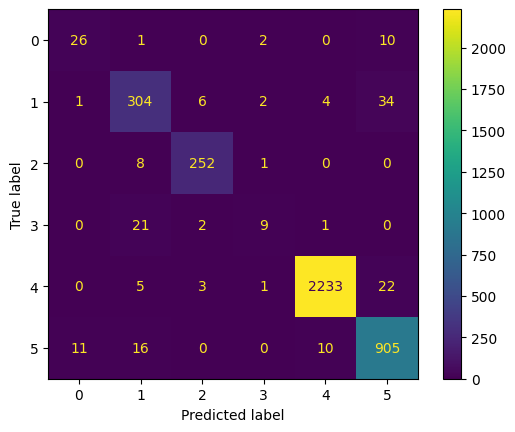

In [ ]:
# from xgboost import XGBClassifier
model_3 = xgb.XGBClassifier()

# Train the model
model_3.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_3.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=model_3.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_3.classes_)
disp.plot()

### Result for xgBoost Classifier¶ (kaggle score 0.95520 , with_pipeline 0.95400 V29)
Accuracy: 0.9580976863753213

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.69      0.71        39
           1       0.86      0.87      0.87       351
           2       0.95      0.96      0.96       261
           3       0.54      0.21      0.30        33
           4       0.99      0.98      0.99      2264
           5       0.93      0.96      0.95       942

    accuracy                           0.96      3890
   macro avg       0.83      0.78      0.80      3890
weighted avg       0.96      0.96      0.96      3890

Confusion Matrix:
 [[  27    0    0    1    0   11]
 [   2  306    7    1    5   30]
 [   0    7  250    2    1    1]
 [   0   22    3    7    1    0]
 [   0    6    2    2 2229   25]
 [   8   14    0    0   12  908]]


## 1. Logistic regression

Accuracy: 0.9465295629820052

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.56      0.68        39
           1       0.85      0.82      0.83       351
           2       0.91      0.95      0.93       261
           3       0.71      0.15      0.25        33
           4       0.98      0.98      0.98      2264
           5       0.91      0.96      0.93       942

    accuracy                           0.95      3890
   macro avg       0.87      0.74      0.77      3890
weighted avg       0.95      0.95      0.94      3890



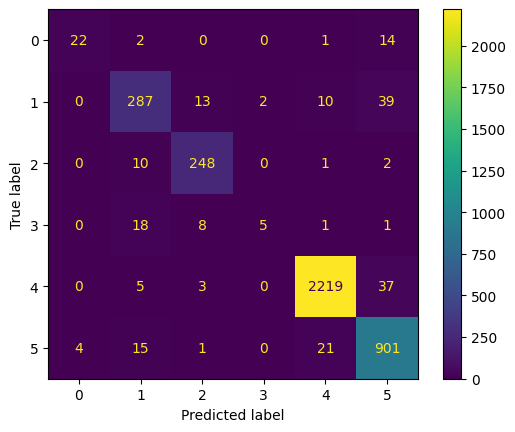

In [ ]:
model_1 = LogisticRegression(random_state = 42, max_iter = 1000)

# Train the model
model_1.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_1.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=model_1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_1.classes_)
disp.plot()

### Result for Logistic regression ( kaggle score = 0.93920 v24)
Accuracy: 0.9467866323907455

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.56      0.68        39
           1       0.85      0.82      0.83       351
           2       0.91      0.95      0.93       261
           3       0.71      0.15      0.25        33
           4       0.98      0.98      0.98      2264
           5       0.91      0.95      0.93       942

    accuracy                           0.95      3890
   macro avg       0.87      0.74      0.77      3890
weighted avg       0.95      0.95      0.94      3890

Confusion Matrix:
 [[  22    2    0    0    1   14]
 [   0  287   13    2   11   38]
 [   0   10  248    0    1    2]
 [   0   19    7    5    1    1]
 [   0    5    3    0 2222   34]
 [   4   15    1    0   23  899]]

## 2. KNeighborsClassifier

Accuracy: 0.8719794344473007

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.21      0.32        39
           1       0.74      0.54      0.63       351
           2       0.90      0.83      0.86       261
           3       0.50      0.06      0.11        33
           4       0.92      0.95      0.94      2264
           5       0.79      0.87      0.83       942

    accuracy                           0.87      3890
   macro avg       0.76      0.58      0.61      3890
weighted avg       0.87      0.87      0.86      3890



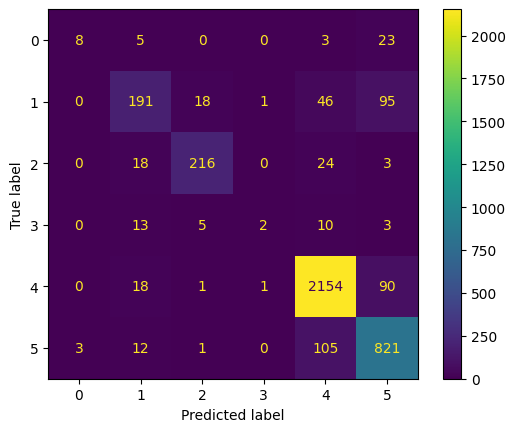

In [ ]:
model_2 = KNeighborsClassifier(n_neighbors=7)

# Train the model
model_2.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_2.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=model_2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_2.classes_)
disp.plot()

### Result for KNeighborsClassifier

Accuracy: 0.8717223650385604

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.18      0.28        39
           1       0.75      0.52      0.62       351
           2       0.89      0.85      0.87       261
           3       0.25      0.03      0.05        33
           4       0.92      0.95      0.94      2264
           5       0.79      0.87      0.83       942

    accuracy                           0.87      3890
   macro avg       0.71      0.57      0.60      3890
weighted avg       0.86      0.87      0.86      3890

Confusion Matrix:
 [[   7    4    0    0    4   24]
 [   0  183   19    2   50   97]
 [   0   13  221    0   24    3]
 [   1   14    5    1    9    3]
 [   0   18    2    1 2156   87]
 [   3   12    1    0  103  823]]

## 4. Random Forest classifier

Accuracy: 0.9460154241645244

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.41      0.56        39
           1       0.87      0.77      0.82       351
           2       0.94      0.92      0.93       261
           3       1.00      0.09      0.17        33
           4       0.98      0.98      0.98      2264
           5       0.89      0.98      0.94       942

    accuracy                           0.95      3890
   macro avg       0.93      0.69      0.73      3890
weighted avg       0.95      0.95      0.94      3890



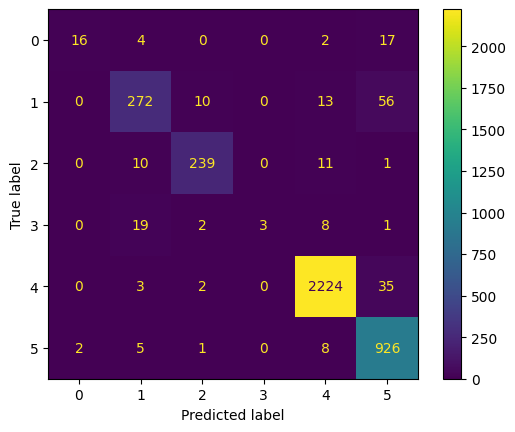

In [ ]:
model_4 = RandomForestClassifier(random_state=42)

# Train the model
model_4.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_4.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=model_4.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_4.classes_)
disp.plot()

### Result for Random Forest classifier (Kaggle score 0.94280 V25)
Accuracy: 0.9460154241645244

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.41      0.55        39
           1       0.87      0.79      0.83       351
           2       0.95      0.91      0.93       261
           3       1.00      0.09      0.17        33
           4       0.98      0.98      0.98      2264
           5       0.90      0.98      0.94       942

    accuracy                           0.95      3890
   macro avg       0.92      0.69      0.73      3890
weighted avg       0.95      0.95      0.94      3890

Confusion Matrix:
 [[  16    4    0    0    2   17]
 [   0  277    9    0   16   49]
 [   0   10  238    0   13    0]
 [   0   19    1    3   10    0]
 [   0    3    1    0 2222   38]
 [   3    5    1    0    9  924]]

## 5. Decision Tree classifier

Accuracy: 0.9321336760925449

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.51      0.52        39
           1       0.79      0.79      0.79       351
           2       0.89      0.90      0.90       261
           3       0.39      0.36      0.38        33
           4       0.98      0.98      0.98      2264
           5       0.91      0.91      0.91       942

    accuracy                           0.93      3890
   macro avg       0.75      0.74      0.75      3890
weighted avg       0.93      0.93      0.93      3890



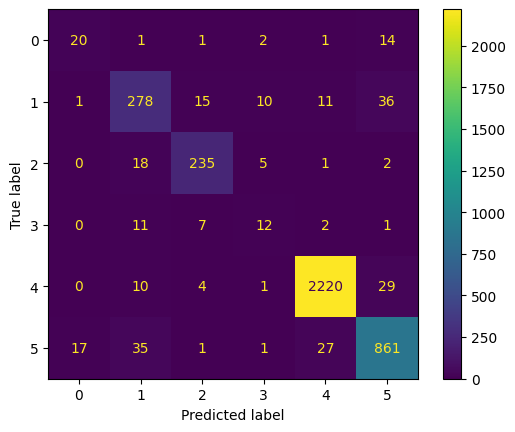

In [ ]:
# from sklearn.tree import DecisionTreeClassifier
model_5 = DecisionTreeClassifier()

# Train the model
model_5.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_5.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=model_5.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_5.classes_)
disp.plot()

### Result for DecisionTreeClassifier

Accuracy: 0.9339331619537276

Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.44      0.45        39
           1       0.80      0.79      0.79       351
           2       0.90      0.90      0.90       261
           3       0.39      0.39      0.39        33
           4       0.98      0.98      0.98      2264
           5       0.91      0.92      0.92       942

    accuracy                           0.93      3890
   macro avg       0.74      0.74      0.74      3890
weighted avg       0.93      0.93      0.93      3890

Confusion Matrix:
 [[  17    2    1    1    1   17]
 [   1  277   13   11   14   35]
 [   0   16  236    5    1    3]
 [   1   10    7   13    1    1]
 [   0    9    4    3 2222   26]
 [  17   34    2    0   21  868]]

## Hyper Parameter Tuning

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END ......................................n_neighbors=3; total time=  43.8s
[CV] END ......................................n_neighbors=3; total time=  43.6s
[CV] END ......................................n_neighbors=5; total time=  43.5s
[CV] END ......................................n_neighbors=5; total time=  43.7s
[CV] END ......................................n_neighbors=7; total time=  43.7s
[CV] END ......................................n_neighbors=7; total time=  43.5s
[CV] END ......................................n_neighbors=9; total time=  43.6s
[CV] END ......................................n_neighbors=9; total time=  43.6s
[CV] END .....................................n_neighbors=11; total time=  43.7s
[CV] END .....................................n_neighbors=11; total time=  43.5s
Accuracy: 0.8719794344473007

Classification Report:
               precision    recall  f1-score   support

           0       0.

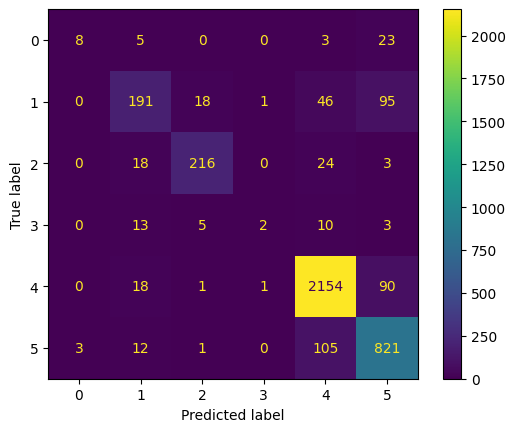

In [ ]:
knn = KNeighborsClassifier()
# lg = LogisticRegression()
# rfc = RandomForestClassifier(random_state=42)
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]
#     'metric': ['euclidean', 'minkowski'], #'manhattan'
#     'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}
model_hpt = GridSearchCV(estimator=knn, param_grid=param_grid, cv=2, n_jobs=-1, verbose=2)

# # taking too much time for execution. not able to pass through the time.
# taking more 30 sec for each run specially for manhattan taking more time.
# #try  for randomizedsearchcv
model_hpt.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_hpt.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=model_hpt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_hpt.classes_)
disp.plot()

In [ ]:
model_hpt.best_params_

{'n_neighbors': 5}

# Best Model selection based on accuracy score

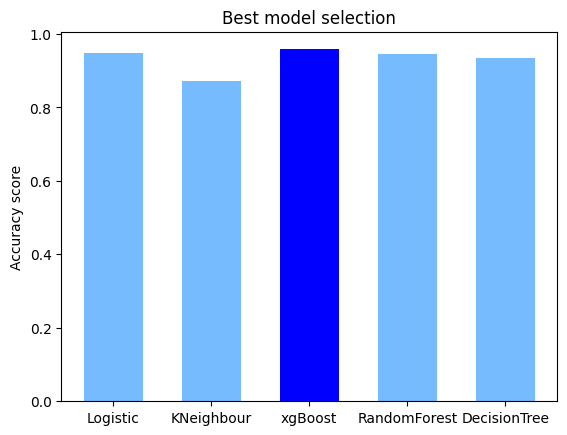

In [ ]:

fig, ax = plt.subplots()

models = ['Logistic', 'KNeighbour', 'xgBoost', 'RandomForest','DecisionTree']
accuracy = [0.9467866323907455, 0.8717223650385604,0.9580976863753213,0.9460154241645244,0.9339331619537276]
bar_colors = ['xkcd:sky blue', 'xkcd:sky blue', 'b', 'xkcd:sky blue','xkcd:sky blue']

ax.bar(models, accuracy,color=bar_colors, width = 0.6)
ax.set_ylabel('Accuracy score')
ax.set_title('Best model selection')
plt.show()

## Final Model Training and output

In [ ]:
# Choose final model for submission
model = model_3

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9546984209163862


In [ ]:
y_pred_final = model.predict(df_test_final)
print(y_pred_final)

[5 4 2 ... 5 5 4]


In [ ]:
decoded_y_pred_final = le.inverse_transform(y_pred_final)
decoded_y_pred_final = pd.DataFrame(decoded_y_pred_final, columns =['Crime_Category'])
print(decoded_y_pred_final)

                     Crime_Category
0                    Violent Crimes
1                   Property Crimes
2     Fraud and White-Collar Crimes
3                   Property Crimes
4       Crimes against Public Order
...                             ...
4995                Property Crimes
4996                Property Crimes
4997                 Violent Crimes
4998                 Violent Crimes
4999                Property Crimes

[5000 rows x 1 columns]


# Submission

In [ ]:
submission = pd.DataFrame({"ID": np.arange(1,5001),
                           "Crime_Category": decoded_y_pred_final['Crime_Category'],
                          }
                         )

submission.to_csv('submission.csv',index=False)

In [ ]:
submission.head()

,ID,Crime_Category
0,1,Violent Crimes
1,2,Property Crimes
2,3,Fraud and White-Collar Crimes
3,4,Property Crimes
4,5,Crimes against Public Order


 ### --------------------------------- End of Code ------------------------------------------